In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

from google.colab import drive

from matplotlib.patches import Rectangle, FancyBboxPatch

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [3]:
drive.mount('/content/drive')
image_path = '/content/drive/My Drive/capstone/data/images_original'

Mounted at /content/drive


In [4]:
images = []
labels = []

for genre in os.listdir(image_path):
    genre_path = os.path.join(image_path, genre)
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith(".png"):
                file_path = os.path.join(genre_path, filename)
                image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    labels.append(genre)
                else:
                    print(f"Image {file_path} couldn't be loaded")

X = np.array(images)
y = np.array(labels)

print("Images shape:", X.shape)
print("Labels shape:", y.shape)

Images shape: (999, 288, 432, 3)
Labels shape: (999,)


In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Convert categorical labels into numeric values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [7]:
# Apply scaling
X_train = X_train / 255.0
X_test = X_test / 255.0

# Train Models

### Convolutional Neural Network (CNN)

In [ ]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

def build_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
               kernel_size=hp.Choice('conv_1_kernel', values=[2, 3]),
               activation='relu',
               input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
               kernel_size=hp.Choice('conv_2_kernel', values=[2, 3]),
               activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=128, step=32),
               kernel_size=hp.Choice('conv_3_kernel', values=[2, 3]),
               activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
              activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='cnn_tuning')

# Train and find best hyperparameters
tuner.search(x=X_train, y=y_train,
             epochs=20,
             validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

Trial 10 Complete [00h 01m 55s]
val_accuracy: 0.6499999761581421

Best val_accuracy So Far: 0.6949999928474426
Total elapsed time: 00h 30m 10s
7/7 [==============================] - 1s 79ms/step - loss: 0.9642 - accuracy: 0.6950


[0.9641821384429932, 0.6949999928474426]

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters found:")
print(f" - Conv_1 filter: {best_hps.get('conv_1_filter')}")
print(f" - Conv_1 kernel size: {best_hps.get('conv_1_kernel')}")
print(f" - Conv_2 filter: {best_hps.get('conv_2_filter')}")
print(f" - Conv_2 kernel size: {best_hps.get('conv_2_kernel')}")
print(f" - Conv_3 filter: {best_hps.get('conv_3_filter')}")
print(f" - Conv_3 kernel size: {best_hps.get('conv_3_kernel')}")
print(f" - Dense units: {best_hps.get('dense_units')}")
print(f" - Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters found:
 - Conv_1 filter: 96
 - Conv_1 kernel size: 2
 - Conv_2 filter: 96
 - Conv_2 kernel size: 2
 - Conv_3 filter: 64
 - Conv_3 kernel size: 3
 - Dense units: 256
 - Learning rate: 0.0001


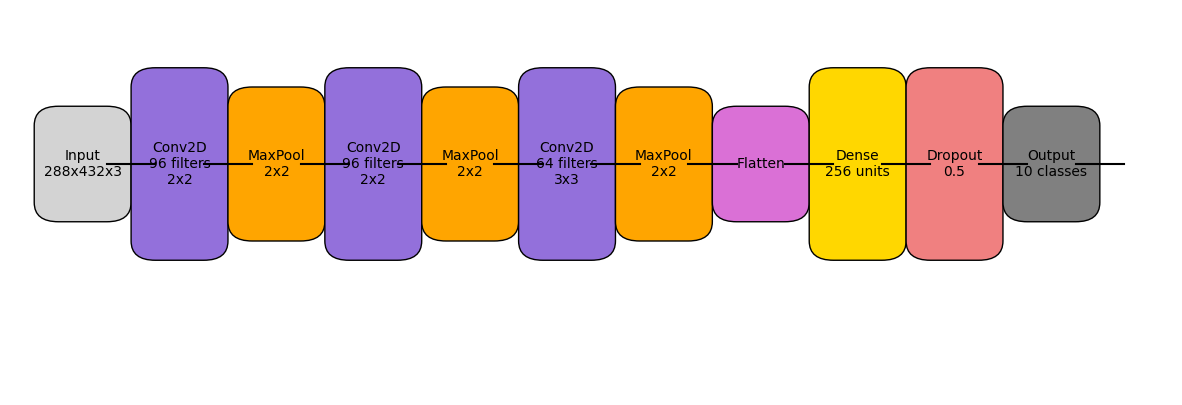

In [ ]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

def draw_cnn():
    fig, ax = plt.subplots(figsize=(15, 5))

    # Input Layer
    input_layer = FancyBboxPatch((0.1, 0.5), 0.1, 0.2, boxstyle="round,pad=0.05", edgecolor="black", facecolor="lightgrey")
    ax.add_patch(input_layer)
    plt.text(0.15, 0.6, "Input\n288x432x3", ha='center', va='center', fontsize=10)

    # First Conv Layer
    conv1 = FancyBboxPatch((0.3, 0.4), 0.1, 0.4, boxstyle="round,pad=0.05", edgecolor="black", facecolor="mediumpurple")
    ax.add_patch(conv1)
    plt.text(0.35, 0.6, "Conv2D\n96 filters\n2x2", ha='center', va='center', fontsize=10)

    # First Pooling Layer
    pool1 = FancyBboxPatch((0.5, 0.45), 0.1, 0.3, boxstyle="round,pad=0.05", edgecolor="black", facecolor="orange")
    ax.add_patch(pool1)
    plt.text(0.55, 0.6, "MaxPool\n2x2", ha='center', va='center', fontsize=10)

    # Second Conv Layer
    conv2 = FancyBboxPatch((0.7, 0.4), 0.1, 0.4, boxstyle="round,pad=0.05", edgecolor="black", facecolor="mediumpurple")
    ax.add_patch(conv2)
    plt.text(0.75, 0.6, "Conv2D\n96 filters\n2x2", ha='center', va='center', fontsize=10)

    # Second Pooling Layer
    pool2 = FancyBboxPatch((0.9, 0.45), 0.1, 0.3, boxstyle="round,pad=0.05", edgecolor="black", facecolor="orange")
    ax.add_patch(pool2)
    plt.text(0.95, 0.6, "MaxPool\n2x2", ha='center', va='center', fontsize=10)

    # Third Conv Layer
    conv3 = FancyBboxPatch((1.1, 0.4), 0.1, 0.4, boxstyle="round,pad=0.05", edgecolor="black", facecolor="mediumpurple")
    ax.add_patch(conv3)
    plt.text(1.15, 0.6, "Conv2D\n64 filters\n3x3", ha='center', va='center', fontsize=10)

    # Third Pooling Layer
    pool3 = FancyBboxPatch((1.3, 0.45), 0.1, 0.3, boxstyle="round,pad=0.05", edgecolor="black", facecolor="orange")
    ax.add_patch(pool3)
    plt.text(1.35, 0.6, "MaxPool\n2x2", ha='center', va='center', fontsize=10)

    # Flatten Layer
    flatten = FancyBboxPatch((1.5, 0.5), 0.1, 0.2, boxstyle="round,pad=0.05", edgecolor="black", facecolor="orchid")
    ax.add_patch(flatten)
    plt.text(1.55, 0.6, "Flatten", ha='center', va='center', fontsize=10)

    # Dense Layer
    dense = FancyBboxPatch((1.7, 0.4), 0.1, 0.4, boxstyle="round,pad=0.05", edgecolor="black", facecolor="gold")
    ax.add_patch(dense)
    plt.text(1.75, 0.6, "Dense\n256 units", ha='center', va='center', fontsize=10)

    # Dropout Layer
    dropout = FancyBboxPatch((1.9, 0.4), 0.1, 0.4, boxstyle="round,pad=0.05", edgecolor="black", facecolor="lightcoral")
    ax.add_patch(dropout)
    plt.text(1.95, 0.6, "Dropout\n0.5", ha='center', va='center', fontsize=10)

    # Output Layer
    output = FancyBboxPatch((2.1, 0.5), 0.1, 0.2, boxstyle="round,pad=0.05", edgecolor="black", facecolor="grey")
    ax.add_patch(output)
    plt.text(2.15, 0.6, f"Output\n{num_classes} classes", ha='center', va='center', fontsize=10)

    # Connections
    for i in range(11):
        plt.plot([0.2 + 0.2 * i, 0.3 + 0.2 * i], [0.6, 0.6], 'k-')

    ax.set_xlim(0, 2.4)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

draw_cnn()